## EDA: Sustainbench dataset

Using the [SustainBench dataset](https://github.com/sustainlab-group/sustainbench) from an interdisciplinary research group from Stanford, CalTech, and UC Berkeley. 

I'll explore and plot our data for six features, which are survey labels relevant to the UN Sustainability Goals:
- `asset_index`
- `water_index`
- `sanitation_index`
- `women_bmi`
- `women_edu`
- `under5_mort`

Out of interest, I'll also pull an additional two country-level features from geopandas:
- `gdp_md_est`
- `pop_est`

I'll look to uncover general trends in these features by country, continent, and year. I'll also see if all six SustainBench features are fit to be targets for a later ML/DL approach.

Some more questions I'd like to answer:
1. Are there any filters we need to add on this dataset, for example on year, continent, or country?
2. How does the correlation between these six features change over time? How about by country/continent?

## Results
- There are 117644 unique survey results. These results cover the years 1996-2019 and cover 56 countries in South and Central America, Southeast Asia, (mostly sub-saharan) Africa, and a couple of countries in Eastern Europe and northern Africa. 
- The indices (`asset_index`, `water_index`, `sanitation_index`) were not collected before 2004. We'll limit our downstream analyses to all data collected in 2004 or later (which consist of 86% of the original data, or ~100K rows). Removing these earlier dates reduces the missing value rate to under 20% for all potential target columns.
- `under5_mort` may not be a good target - it is incredibly sparse. 80% of its values are either NaN (10%) or 0 (70%). As a side note, it is also hardly correlated with any of the other features, likely in part due to its sparsity. In downstream analyses, we'll build models for the other five features of interest.
- India has by far the most examples - 25983 examples, or 22% of the original dataset. The vast majority of these examples were collected in 2015.
- Qualitatively, the correlation between these six features differs dramatically by geography (both by continent and by country). Though it may not be possible to build separate models per country using this small dataset, we should confirm that our model performs well across different geographies (and, for example, not just well for India, the country with by far the most examples). Specifically, I investigated correlation matrices for each continent, the top 10 most surveyed countries, and the top 10 most surveyed countries normalized by population.

In [1]:
!pip3 install pandas numpy seaborn matplotlib geopandas shapely

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

## Load data and enrich with geopandas

In [3]:
df = pd.read_csv('../data/dhs_final_labels.csv')
metadata = ['cname', 'year', 'lat', 'lon']
features = ['asset_index', 'women_edu', 'women_bmi', 'sanitation_index', 'water_index', 'under5_mort']
df = df[metadata+features]

df.head()

,cname,year,lat,lon,asset_index,women_edu,women_bmi,sanitation_index,water_index,under5_mort
0,AL,2008,40.822652,19.838321,2.430596,9.500000,24.365000,4.833333,3.444444,0.0
1,AL,2008,40.696846,20.007555,2.867678,8.600000,23.104000,4.950000,4.700000,NaN
2,AL,2008,40.750037,19.974262,2.909049,9.666667,22.387778,4.777778,4.500000,NaN
3,AL,2008,40.798931,19.863338,2.881122,9.952381,27.084500,4.789474,4.947368,NaN
4,AL,2008,40.746123,19.843885,2.546830,8.937500,24.523125,4.526316,4.684211,0.0


In [4]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

# this is a map that goes with geopandas
# it stores a country's estimated population and GDP too
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [5]:
world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    int64   
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    float64 
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


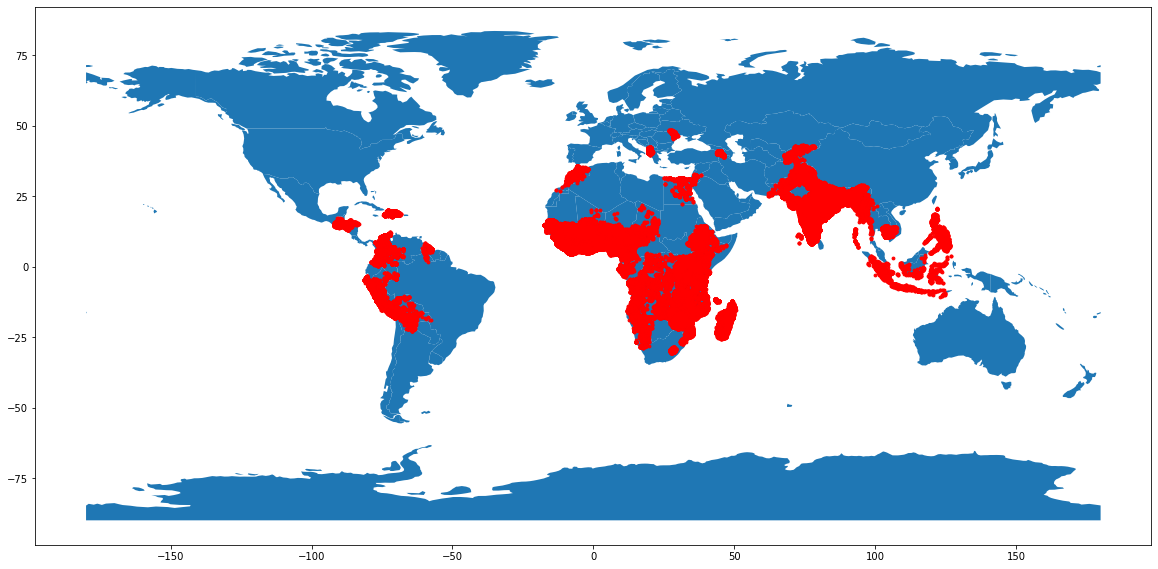

In [6]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   

gdf.plot(ax=world.plot(figsize=(20, 14)), marker='o', color='red', markersize=8);

In [7]:
def assign_point_to_poly(point, polys):
    for key, poly in polys.items():
        if poly.contains(point) or poly.touches(point):
            return key
    return None

In [8]:
country_polys = dict(zip(world.name, world.geometry))
gdf['country'] = gdf.geometry.apply(lambda point: assign_point_to_poly(point, country_polys))

In [9]:
# number of locations that weren't mapped to a country
# because of this, we'll use cname instead of country
print(np.sum(gdf.country.isna()))

3332


In [10]:
# also, seems like the country mapping was not the most accurate
# getting Bangladesh and Pakistan mapped to India...
gdf[gdf.country == 'India'].cname.value_counts()

IA    25983
BD       84
NP       74
PK       28
MM        1
Name: cname, dtype: int64

In [11]:
world = world[['name', 'continent', 'pop_est', 'gdp_md_est']]
world.columns = ['country', 'continent', 'pop_est', 'gdp_md_est']
gdf = gdf.merge(world, on='country', how='left')

In [12]:
gdf.head()

,cname,year,lat,lon,asset_index,women_edu,women_bmi,sanitation_index,water_index,under5_mort,geometry,country,continent,pop_est,gdp_md_est
0,AL,2008,40.822652,19.838321,2.430596,9.500000,24.365000,4.833333,3.444444,0.0,POINT (19.83832 40.82265),Albania,Europe,3047987.0,33900.0
1,AL,2008,40.696846,20.007555,2.867678,8.600000,23.104000,4.950000,4.700000,NaN,POINT (20.00755 40.69685),Albania,Europe,3047987.0,33900.0
2,AL,2008,40.750037,19.974262,2.909049,9.666667,22.387778,4.777778,4.500000,NaN,POINT (19.97426 40.75004),Albania,Europe,3047987.0,33900.0
3,AL,2008,40.798931,19.863338,2.881122,9.952381,27.084500,4.789474,4.947368,NaN,POINT (19.86334 40.79893),Albania,Europe,3047987.0,33900.0
4,AL,2008,40.746123,19.843885,2.546830,8.937500,24.523125,4.526316,4.684211,0.0,POINT (19.84389 40.74612),Albania,Europe,3047987.0,33900.0


In [13]:
countries = list(gdf.cname.unique())
continents = list(gdf.continent.unique())

## Quick overview

In [14]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 117644 entries, 0 to 117643
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   cname             117644 non-null  object  
 1   year              117644 non-null  int64   
 2   lat               117644 non-null  float64 
 3   lon               117644 non-null  float64 
 4   asset_index       86936 non-null   float64 
 5   women_edu         117062 non-null  float64 
 6   women_bmi         94866 non-null   float64 
 7   sanitation_index  89271 non-null   float64 
 8   water_index       87938 non-null   float64 
 9   under5_mort       105582 non-null  float64 
 10  geometry          117644 non-null  geometry
 11  country           114312 non-null  object  
 12  continent         114312 non-null  object  
 13  pop_est           114312 non-null  float64 
 14  gdp_md_est        114312 non-null  float64 
dtypes: float64(10), geometry(1), int64(1), obje

In [15]:
gdf.describe()

,year,lat,lon,asset_index,women_edu,women_bmi,sanitation_index,water_index,under5_mort,pop_est,gdp_md_est
count,117644.000000,117644.000000,117644.000000,86936.000000,117062.000000,94866.000000,89271.000000,87938.000000,105582.000000,1.143120e+05,1.143120e+05
mean,2010.964894,10.875259,29.263579,0.174589,6.354988,23.296365,3.086101,3.763723,18.163958,3.323020e+08,2.249479e+06
std,5.301742,16.276815,54.533060,1.848209,3.468181,2.946691,1.282027,1.123908,46.747577,5.200056e+08,3.554195e+06
min,1996.000000,-30.588811,-92.176053,-3.823164,0.000000,15.758333,1.000000,1.000000,0.000000,5.919190e+05,2.851000e+03
25%,2007.000000,0.057170,-0.137666,-1.451730,3.750000,21.148019,2.037037,3.037037,0.000000,1.546073e+07,3.809000e+04
50%,2013.000000,11.982408,32.822764,0.179011,6.333333,22.804907,2.958333,3.933333,0.000000,3.957012e+07,1.747000e+05
75%,2015.000000,24.617686,77.497416,1.842407,8.916667,24.898071,4.272727,4.826087,0.000000,2.049249e+08,1.105000e+06
max,2019.000000,48.436031,126.842321,3.607050,17.800000,48.111667,5.000000,5.000000,692.307692,1.379303e+09,2.114000e+07


In [16]:
gdf.isna().sum() / gdf.shape[0]

cname               0.000000
year                0.000000
lat                 0.000000
lon                 0.000000
asset_index         0.261025
women_edu           0.004947
women_bmi           0.193618
sanitation_index    0.241177
water_index         0.252508
under5_mort         0.102530
geometry            0.000000
country             0.028323
continent           0.028323
pop_est             0.028323
gdp_md_est          0.028323
dtype: float64

In [17]:
# number of unique countries surveyed
gdf.cname.nunique()

56

In [18]:
# number of unique locations surveyed
gdf.drop_duplicates(['lat', 'lon']).shape[0]

114474

In [19]:
# number of surveys per country
gdf.groupby('cname').size().sort_values(ascending=False)

cname
IA    26747
EG     5899
PE     5347
CO     4633
NG     4077
MW     3184
JO     3181
TZ     3059
BD     2931
PH     2761
ET     2561
SN     2415
UG     2379
KH     2236
KE     2227
ML     2018
GH     1950
DR     1944
MD     1750
RW     1686
SL     1678
BF     1618
BJ     1579
ZM     1573
HT     1535
PK     1504
CM     1467
ZW     1409
MZ     1406
LB     1384
ID     1312
NM     1299
GN     1285
NP     1180
LS     1174
AL     1161
BU     1128
HN     1122
BO      997
AO      969
GU      853
CD      785
TG      762
TJ      708
TD      624
AM      621
MA      480
CI      474
MM      441
MB      399
GA      329
KY      314
GY      310
SZ      270
NI      267
KM      242
dtype: int64

In [20]:
# number of surveys per location
gdf.groupby(['lat', 'lon']).size().sort_values(ascending=False)

lat         lon       
-15.494168  -70.131332    3
-17.074976  -70.844006    3
-11.293425  -76.747194    3
-13.512451  -71.881674    3
-12.029135  -77.044910    3
                         ..
 6.810321    8.808429     1
 6.810199   -10.353344    1
 6.809831    1.640788     1
 6.809785   -58.147820    1
 48.436031   27.778731    1
Length: 114474, dtype: int64

In [21]:
# How many locations were surveyed more than once?
n_surveys_per_loc = gdf.groupby(['lat', 'lon']).size().reset_index()
n_loc_more_than_once = sum(n_surveys_per_loc[0] > 1)
n_loc = n_surveys_per_loc.shape[0]
print(f'{n_loc_more_than_once} out of {n_loc} ({round(n_loc_more_than_once/n_loc*100, 2)}%) of locations have been surveyed more than once')

1805 out of 114474 (1.58%) of locations have been surveyed more than once


## Data trends by year

<AxesSubplot:title={'center':'Boxplot for number of datapoints by year'}, xlabel='year', ylabel='Count'>

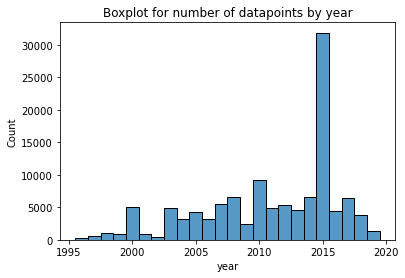

In [22]:
min_year, max_year = gdf.year.min(), gdf.year.max()

plt.figure()
plt.title(f'Boxplot for number of datapoints by year')
sns.histplot(data=gdf, x='year', binrange=(min_year, max_year), discrete=True)

In [23]:
# get the countries and years where the most surveys were collected
gdf.dropna().groupby(['cname', 'year']).size().sort_values(ascending=False)[:10]

cname  year
IA     2015    22840
CO     2010     1830
KE     2014     1409
NG     2018     1294
EG     2014     1261
PE     2009     1004
NG     2013      886
       2008      881
GU     2015      843
MW     2015      810
dtype: int64

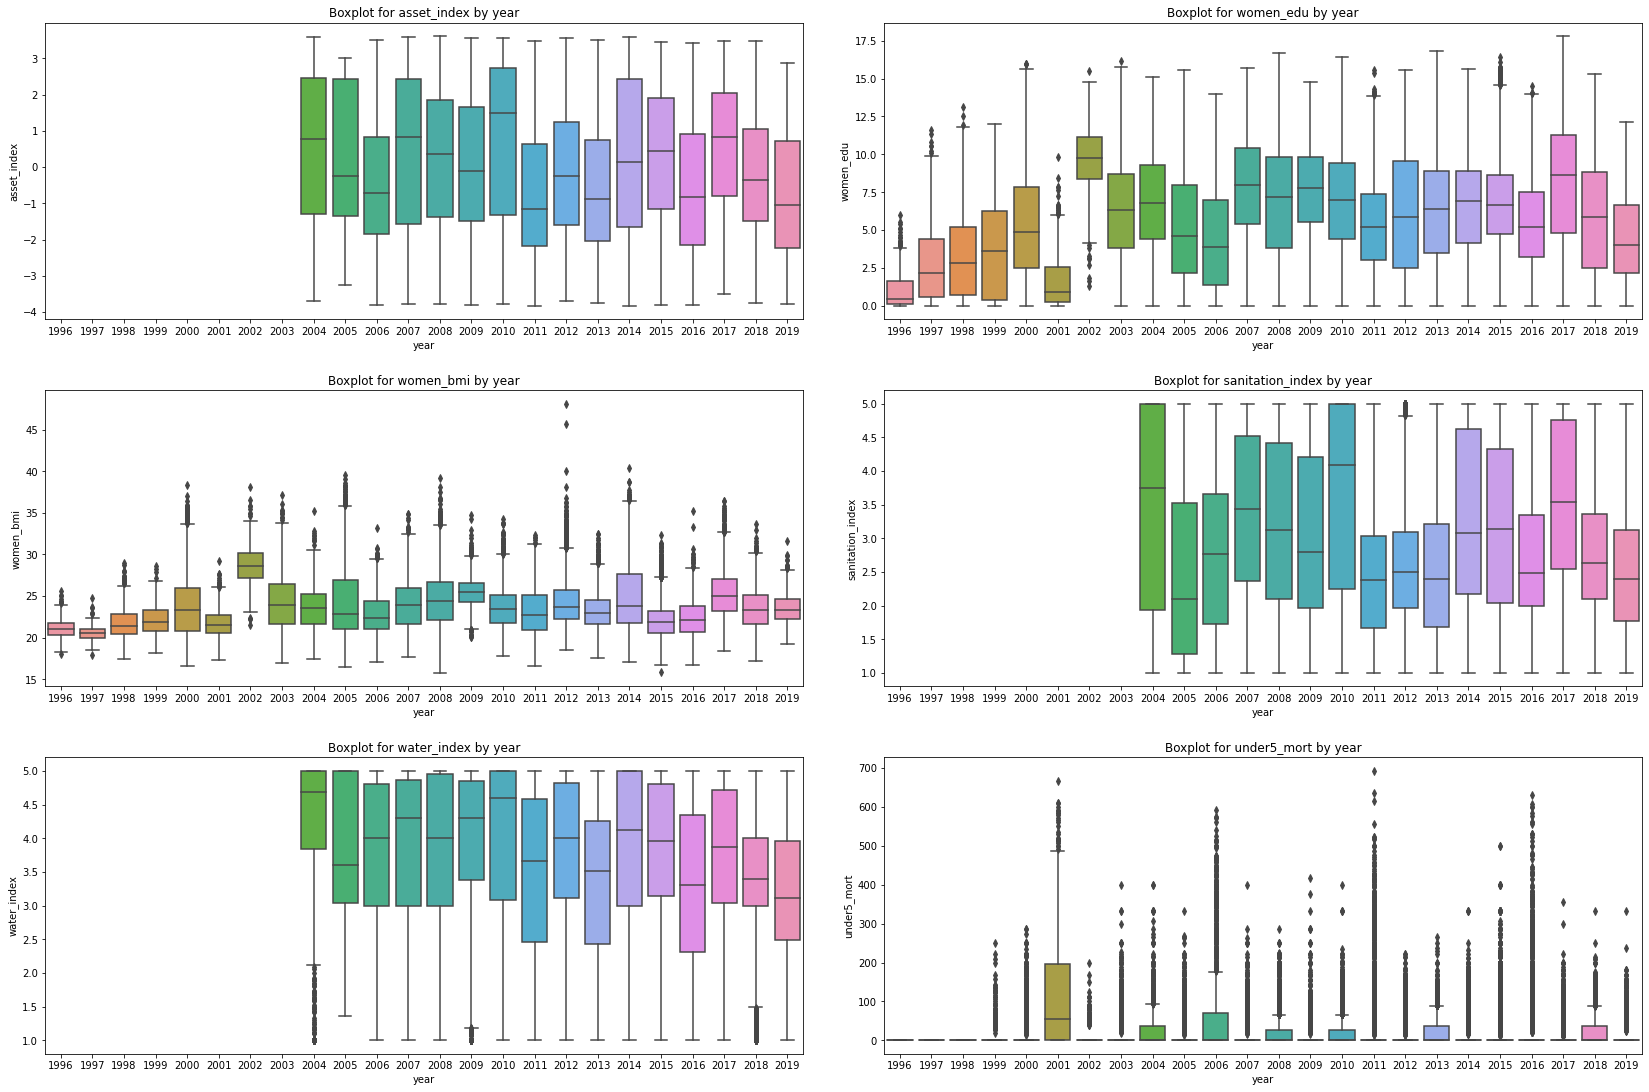

In [24]:
# any general trends by year?
fig, axs = plt.subplots(3, 2, figsize=(24,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by year')
    sns.boxplot(data=gdf, x='year', y=feature, ax=ax)

In [25]:
# missing indexes before 2004, let's see how much data we lose if we only keep 2004-2019 data
print(f'There are {gdf[gdf.year > 2003].shape[0]} examples collected between 2004-2019. This constitutes {round(gdf[gdf.year > 2003].shape[0] / gdf.shape[0] * 100, 2)}% of the original data.')

There are 103485 examples collected between 2004-2019. This constitutes 87.96% of the original data.


In [26]:
# only keep 2004-2019 data
gdf = gdf[gdf.year > 2003]
gdf.describe()

,year,lat,lon,asset_index,women_edu,women_bmi,sanitation_index,water_index,under5_mort,pop_est,gdp_md_est
count,103485.000000,103485.000000,103485.000000,86936.000000,102937.000000,84368.000000,89271.000000,87938.000000,92693.000000,1.006730e+05,1.006730e+05
mean,2012.364362,11.205341,29.749106,0.174589,6.528577,23.260244,3.086101,3.763723,17.769842,3.680444e+08,2.477369e+06
std,3.892959,16.354866,54.351562,1.848209,3.408807,2.863192,1.282027,1.123908,44.748639,5.433475e+08,3.714532e+06
min,2004.000000,-30.588811,-92.176053,-3.823164,0.000000,15.758333,1.000000,1.000000,0.000000,5.919190e+05,2.851000e+03
25%,2010.000000,0.478558,1.908844,-1.451730,4.000000,21.185555,2.037037,3.037037,0.000000,1.466852e+07,3.972000e+04
50%,2014.000000,12.407739,33.625822,0.179011,6.500000,22.803000,2.958333,3.933333,0.000000,4.761574e+07,1.747000e+05
75%,2015.000000,24.778645,77.635719,1.842407,9.035714,24.832036,4.272727,4.826087,0.000000,1.281936e+09,8.721000e+06
max,2019.000000,48.436031,126.571690,3.607050,17.800000,48.111667,5.000000,5.000000,692.307692,1.379303e+09,2.114000e+07


In [27]:
# let's see how much missing data we have with the restricted date range
gdf.isna().sum() / gdf.shape[0]

cname               0.000000
year                0.000000
lat                 0.000000
lon                 0.000000
asset_index         0.159917
women_edu           0.005295
women_bmi           0.184732
sanitation_index    0.137353
water_index         0.150234
under5_mort         0.104286
geometry            0.000000
country             0.027173
continent           0.027173
pop_est             0.027173
gdp_md_est          0.027173
dtype: float64

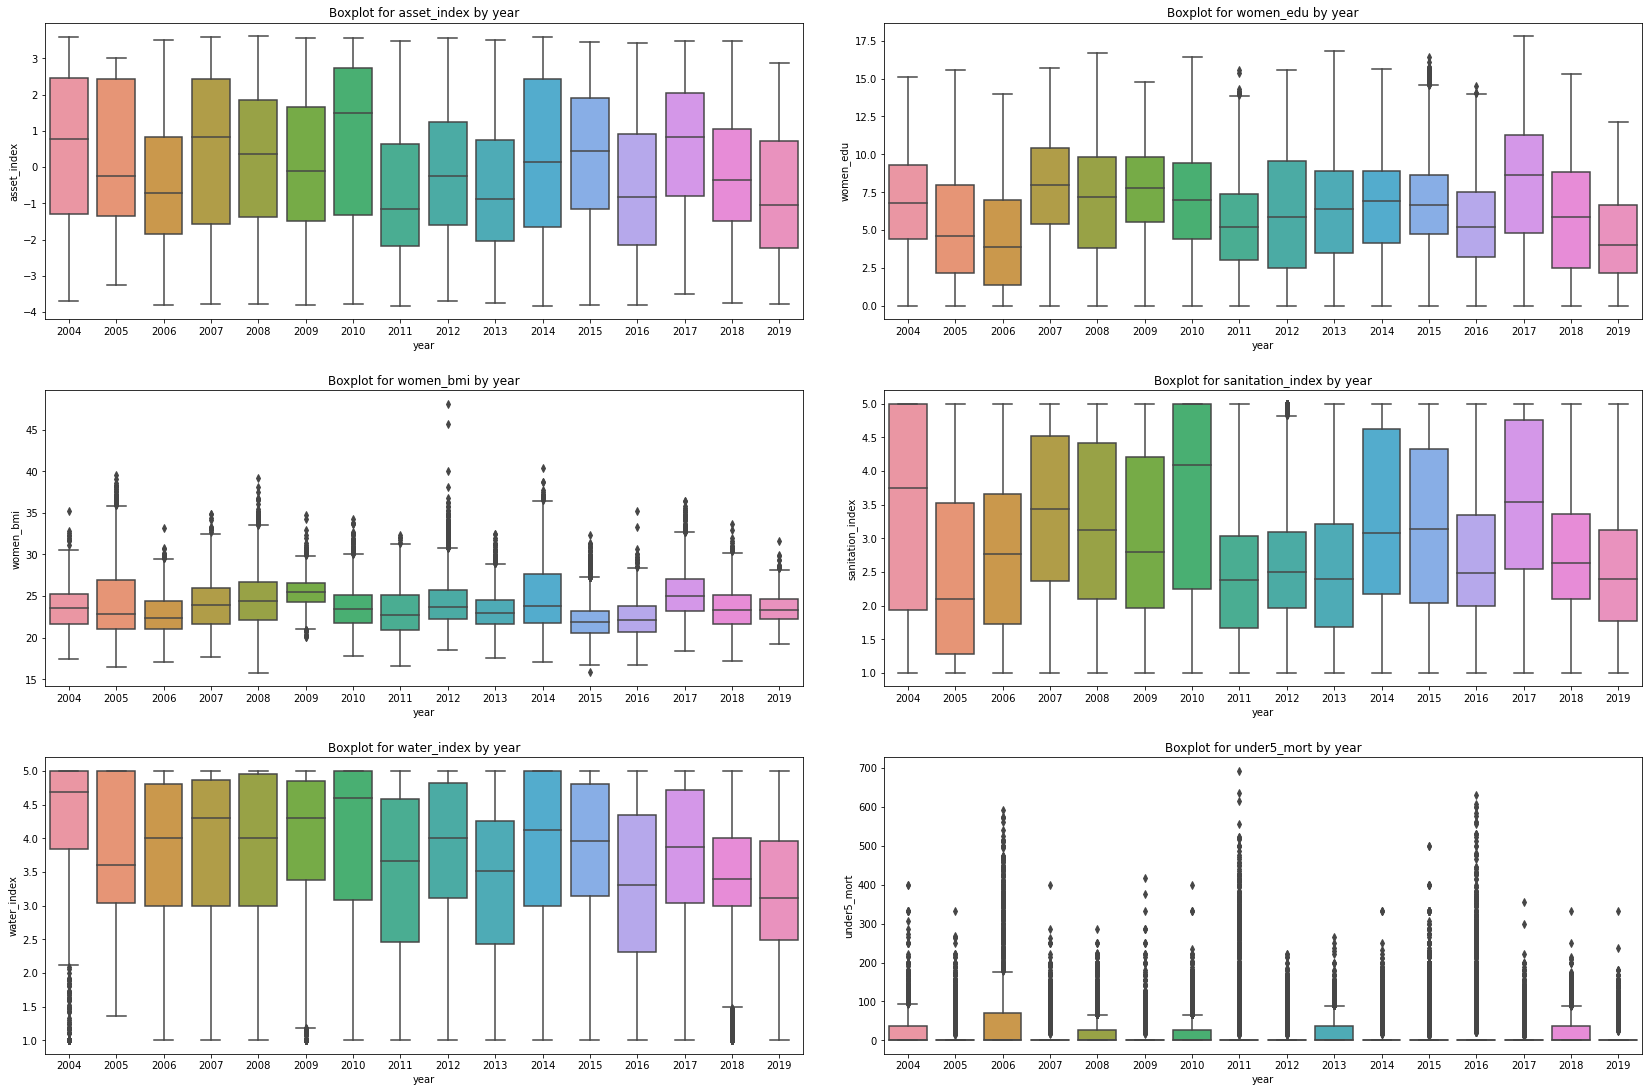

In [28]:
# and boxplots by year for the restricted date range
# difficult to get useful info out of this bc different countries/regions had data collected each year
fig, axs = plt.subplots(3, 2, figsize=(24,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by year')
    sns.boxplot(data=gdf, x='year', y=feature, ax=ax)

## Feature distributions

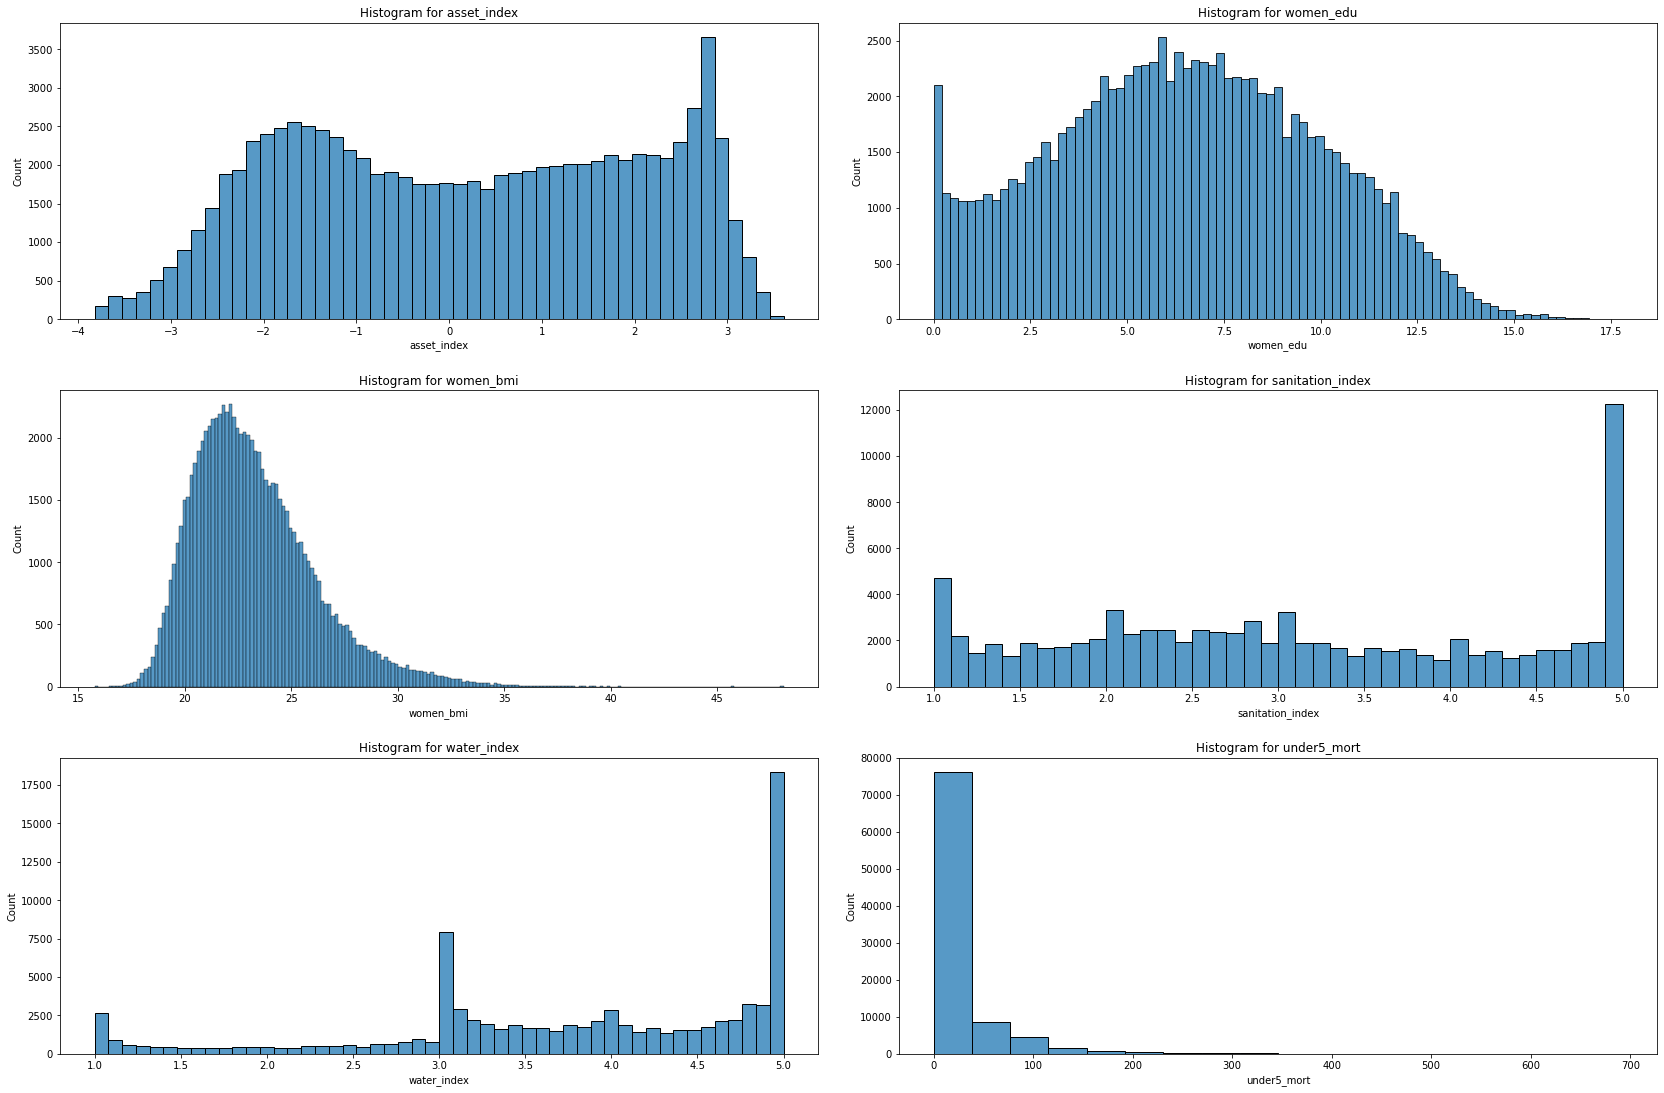

In [29]:
# distributions of each feature
fig, axs = plt.subplots(3, 2, figsize=(24,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Histogram for {feature}')
    sns.histplot(data=gdf, x=feature, ax=ax)

In [30]:
# hmm, let's look at the number of values at certain cutoffs, like 0 for under5_mort
# looks like there are certain values that are arbitrary cutoffs too, like 3 for water_index
cutoff_dict = {
    'women_edu': [0],
    'under5_mort': [0],
    'sanitation_index': [1, 5],
    'water_index': [1, 3, 5],
}

for col, vals in cutoff_dict.items():
    for val in vals:
        print(f'{col} has {sum(gdf[col] == val)} examples ({round(sum(gdf[col] == val) / gdf.shape[0] * 100, 2)}% of the dataset) that are exactly equal to {val}')
    print()

women_edu has 1208 examples (1.17% of the dataset) that are exactly equal to 0

under5_mort has 71940 examples (69.52% of the dataset) that are exactly equal to 0

sanitation_index has 3634 examples (3.51% of the dataset) that are exactly equal to 1
sanitation_index has 10578 examples (10.22% of the dataset) that are exactly equal to 5

water_index has 2571 examples (2.48% of the dataset) that are exactly equal to 1
water_index has 6079 examples (5.87% of the dataset) that are exactly equal to 3
water_index has 16467 examples (15.91% of the dataset) that are exactly equal to 5



Looks like there are a few features I can binarize in this EDA:
- `asset_index` > 0 or `asset_index` < 0
- `sanitation_index` = 5 or `sanitation_index` < 5
- `water_index` = 5 or `water_index` < 5
- `under5_mort` = 0 or `under5_mort` > 0
- `women_edu` > 0 or `women_edu` = 0
- `women_bmi` seems normally distributed!

In [31]:
gdf['asset_index_bin'] = gdf['asset_index'] > 0
gdf['sanitation_index_bin'] = gdf['sanitation_index'] == 5
gdf['water_index_bin'] = gdf['water_index'] == 5
gdf['under5_mort_bin'] = gdf['under5_mort'] == 0
gdf['women_edu_bin'] = gdf['women_edu'] > 0

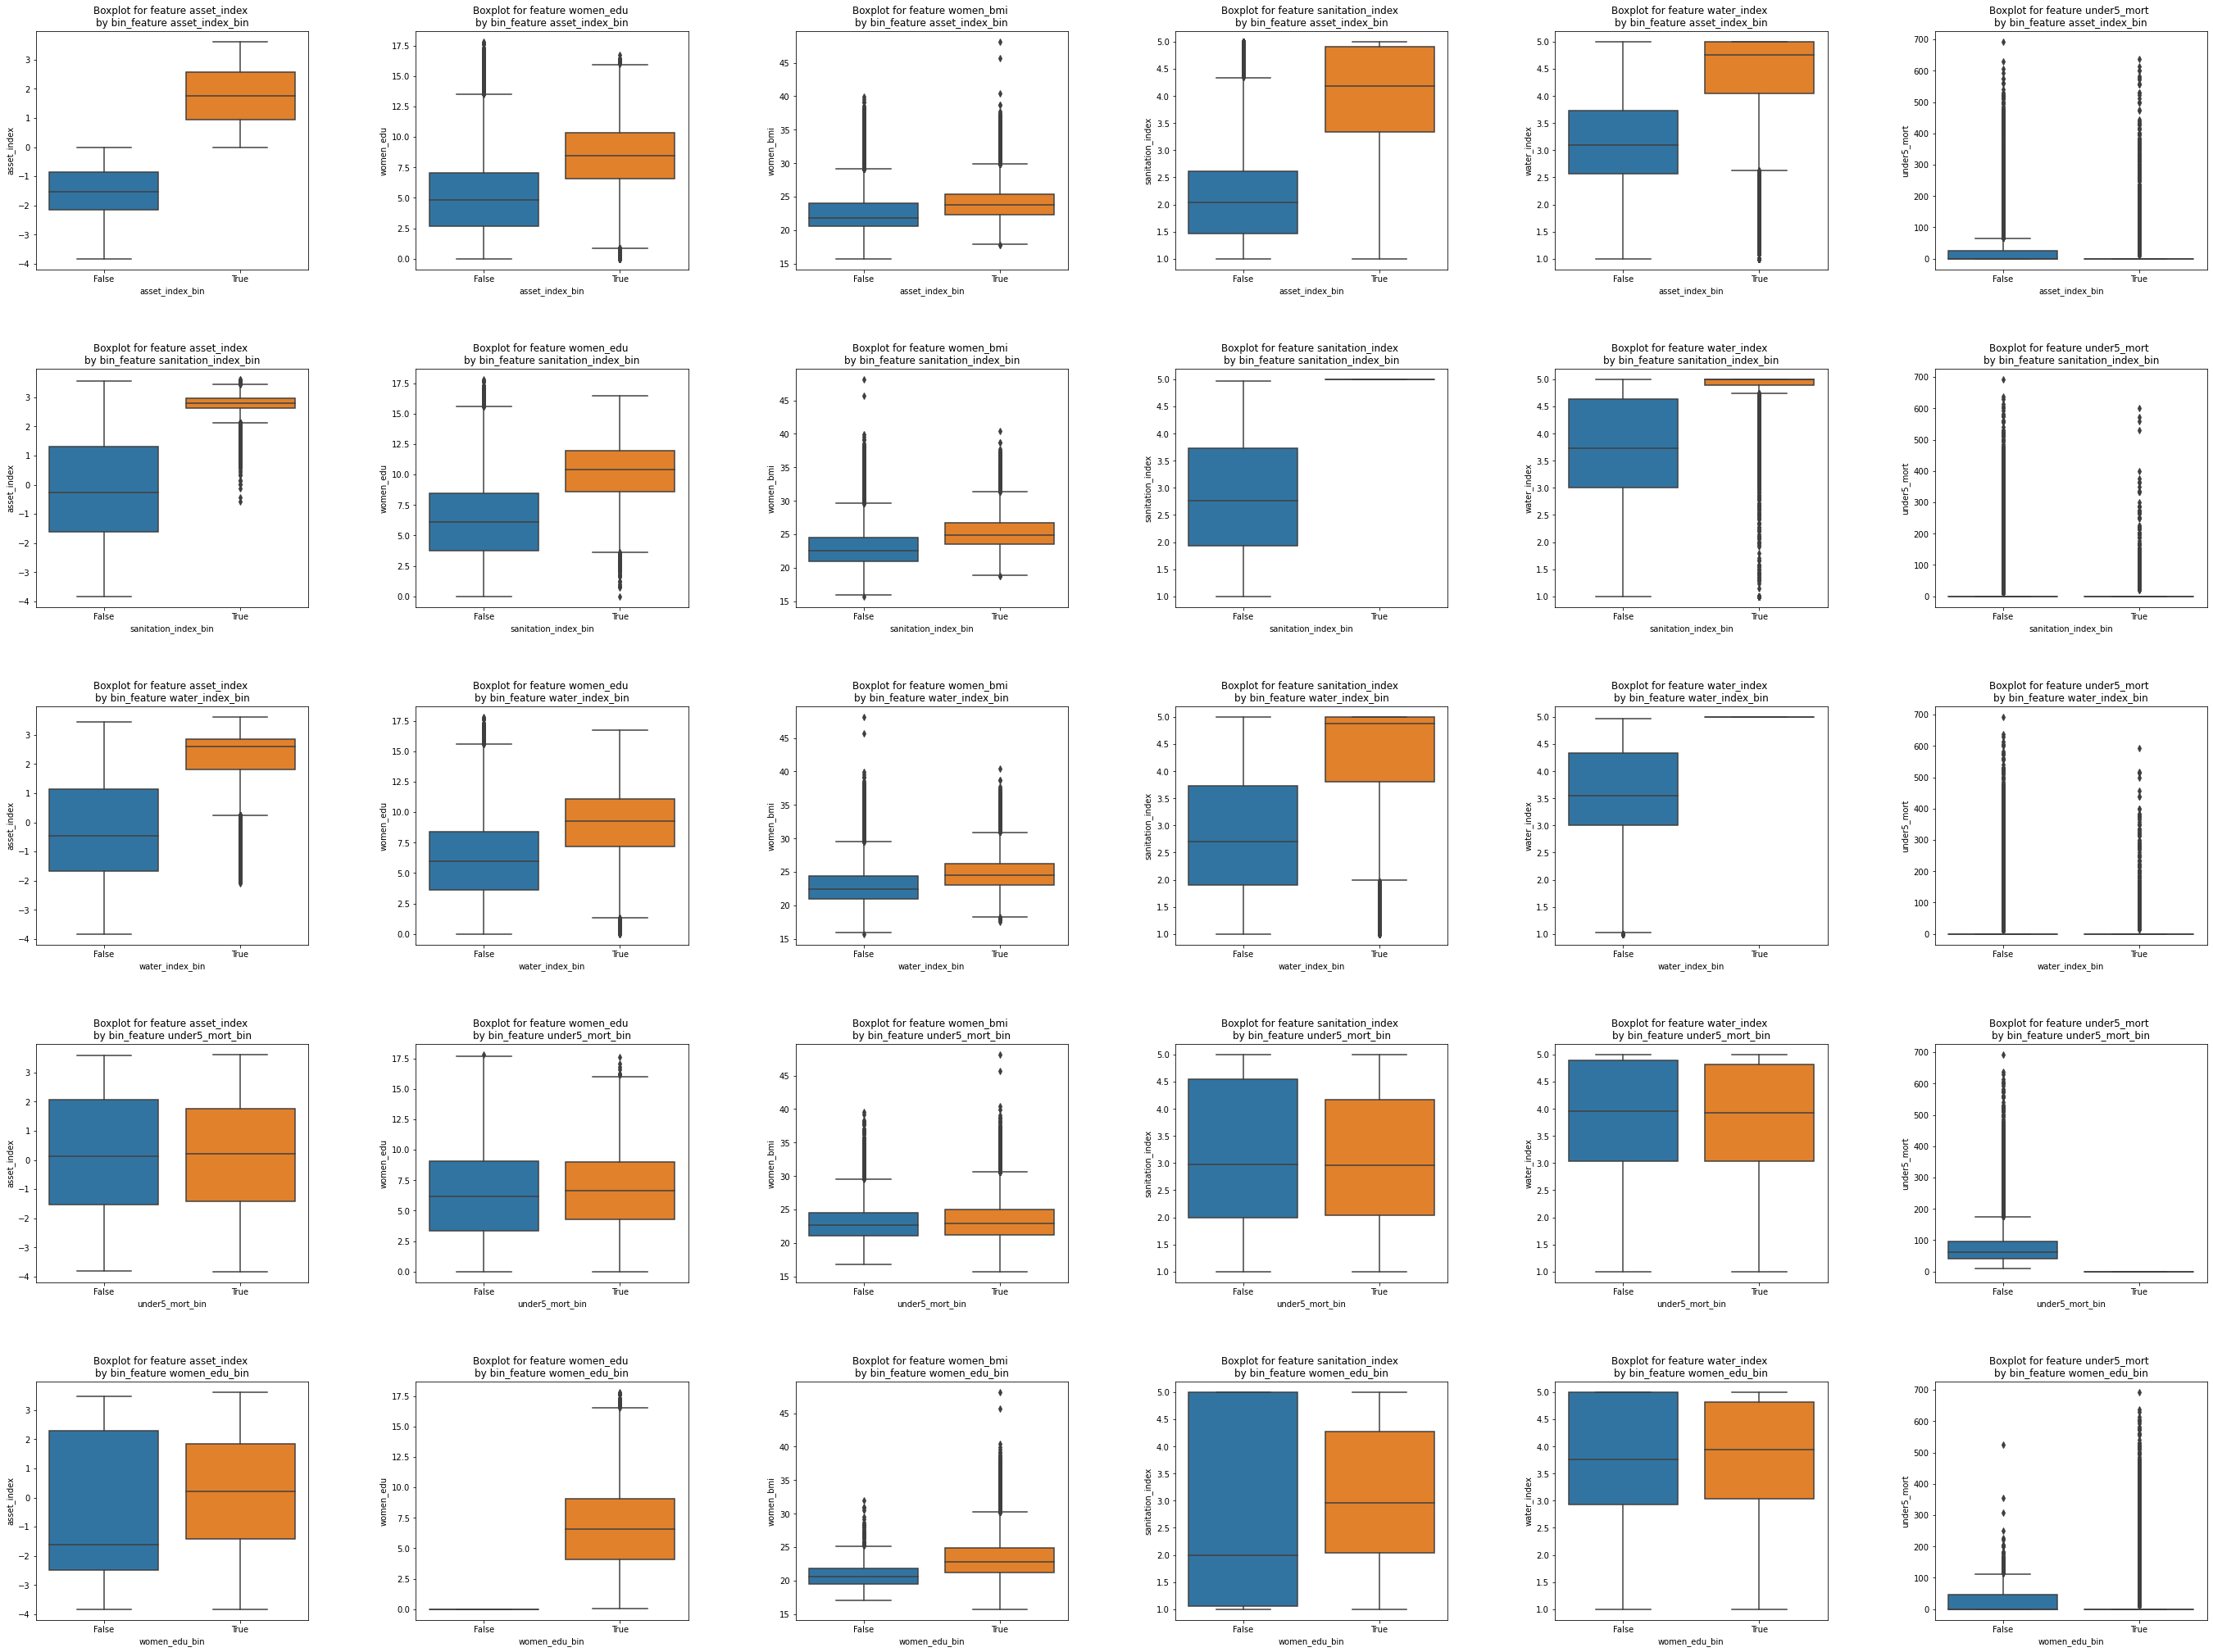

In [32]:
bin_features = ['asset_index_bin', 'sanitation_index_bin', 'water_index_bin', 'under5_mort_bin', 'women_edu_bin']
fig, axs = plt.subplots(len(bin_features), len(features), figsize=(40,30))
plt.tight_layout(pad=10.0)

for i, bin_feature in enumerate(bin_features):
    for j, feature in enumerate(features):
        ax = axs[i][j]
        ax.set_title(f'Boxplot for feature {feature} \nby bin_feature {bin_feature}')
        sns.boxplot(data=gdf, x=bin_feature, y=feature, ax=ax)

## Correlations between features

In [33]:
gdf[features].corr()

,asset_index,women_edu,women_bmi,sanitation_index,water_index,under5_mort
asset_index,1.000000,0.707481,0.554626,0.889270,0.755602,-0.101002
women_edu,0.707481,1.000000,0.484117,0.667386,0.446692,-0.142523
women_bmi,0.554626,0.484117,1.000000,0.532875,0.367428,-0.116969
sanitation_index,0.889270,0.667386,0.532875,1.000000,0.520734,-0.066169
water_index,0.755602,0.446692,0.367428,0.520734,1.000000,-0.058783
under5_mort,-0.101002,-0.142523,-0.116969,-0.066169,-0.058783,1.000000


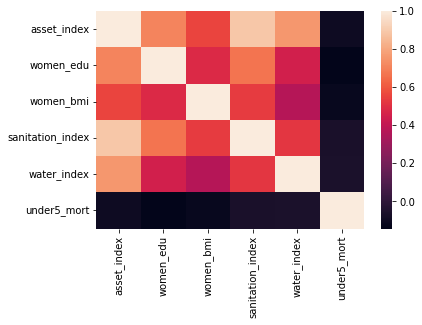

In [34]:
sns.heatmap(gdf[features].corr())
plt.show()

asset_index and women_edu correlation: 0.707
asset_index and women_bmi correlation: 0.555
asset_index and sanitation_index correlation: 0.889
asset_index and water_index correlation: 0.756
asset_index and under5_mort correlation: -0.101
women_edu and women_bmi correlation: 0.484
women_edu and sanitation_index correlation: 0.667
women_edu and water_index correlation: 0.447
women_edu and under5_mort correlation: -0.143
women_bmi and sanitation_index correlation: 0.533
women_bmi and water_index correlation: 0.367
women_bmi and under5_mort correlation: -0.117
sanitation_index and water_index correlation: 0.521
sanitation_index and under5_mort correlation: -0.066
water_index and under5_mort correlation: -0.059


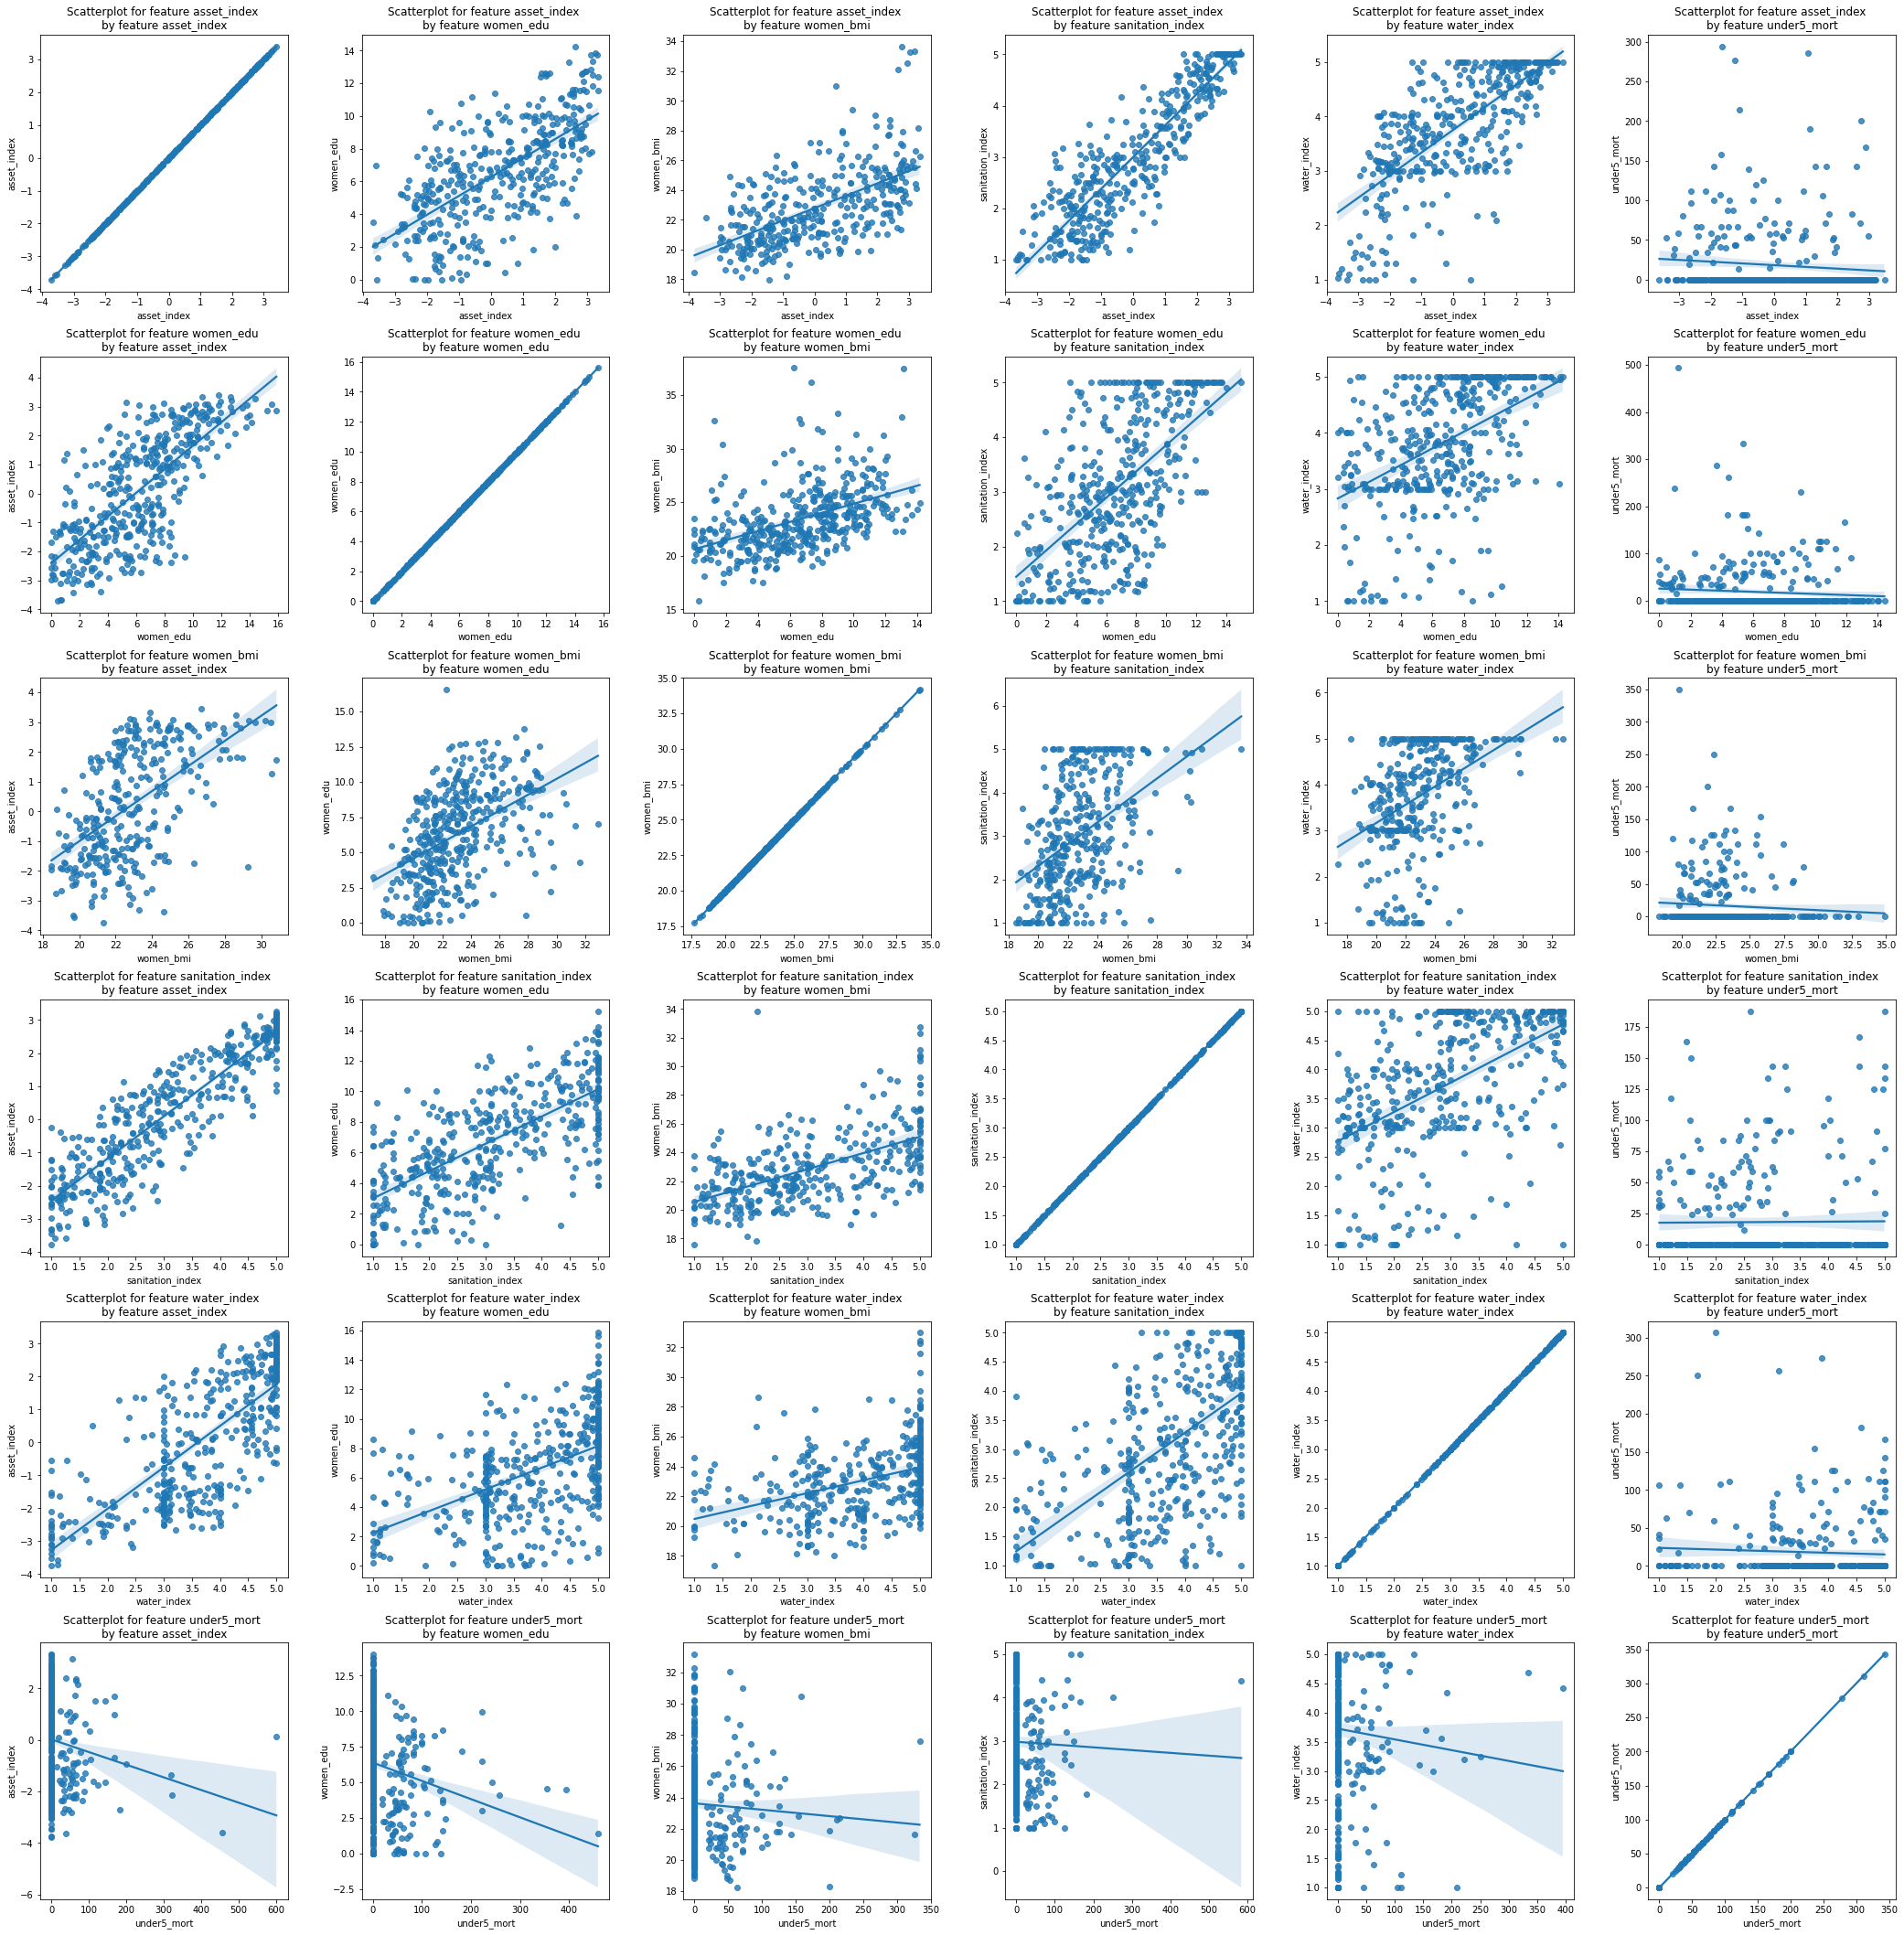

In [35]:
fig, axs = plt.subplots(len(features), len(features), figsize=(30,30))
plt.tight_layout(pad=5.0)

for i, feature1 in enumerate(features):
    for j, feature2 in enumerate(features):
        ax = axs[i][j]
        ax.set_title(f'Scatterplot for feature {feature1} \nby feature {feature2}')
        if i < j:
            print(f'{feature1} and {feature2} correlation: {round(gdf[feature1].corr(gdf[feature2]), 3)}')
        sns.regplot(data=gdf.sample(500), x=feature1, y=feature2, ax=ax)

## EDA at country level

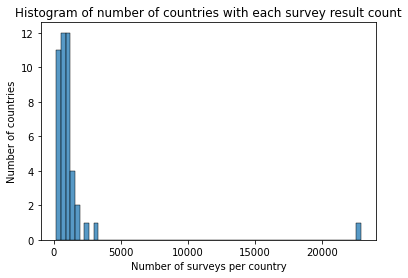

In [36]:
plt.figure()
plt.title('Histogram of number of countries with each survey result count')
plt.xlabel('Number of surveys per country')
plt.ylabel('Number of countries')
sns.histplot(gdf.dropna().groupby('cname').size())
plt.show()

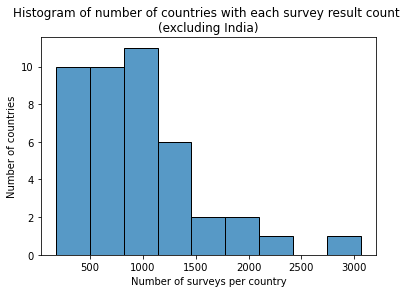

In [37]:
plt.figure()
plt.title('Histogram of number of countries with each survey result count \n(excluding India)')
plt.xlabel('Number of surveys per country')
plt.ylabel('Number of countries')
sns.histplot(gdf[gdf.cname != 'IA'].dropna().groupby('cname').size())
plt.show()

In [38]:
n = 10
top_n_countries = gdf.dropna().groupby('cname').size().sort_values(ascending=False)[:n]
top_n_countries.head(n)

cname
IA    22840
NG     3061
PE     2387
CO     1830
KE     1782
MW     1568
BD     1543
BJ     1276
EG     1261
UG     1174
dtype: int64

In [39]:
np.sum(top_n_countries.reset_index()[0]) / gdf.shape[0]

0.3741798328260134

In [40]:
top_n_countries = list(top_n_countries.reset_index()['cname'])

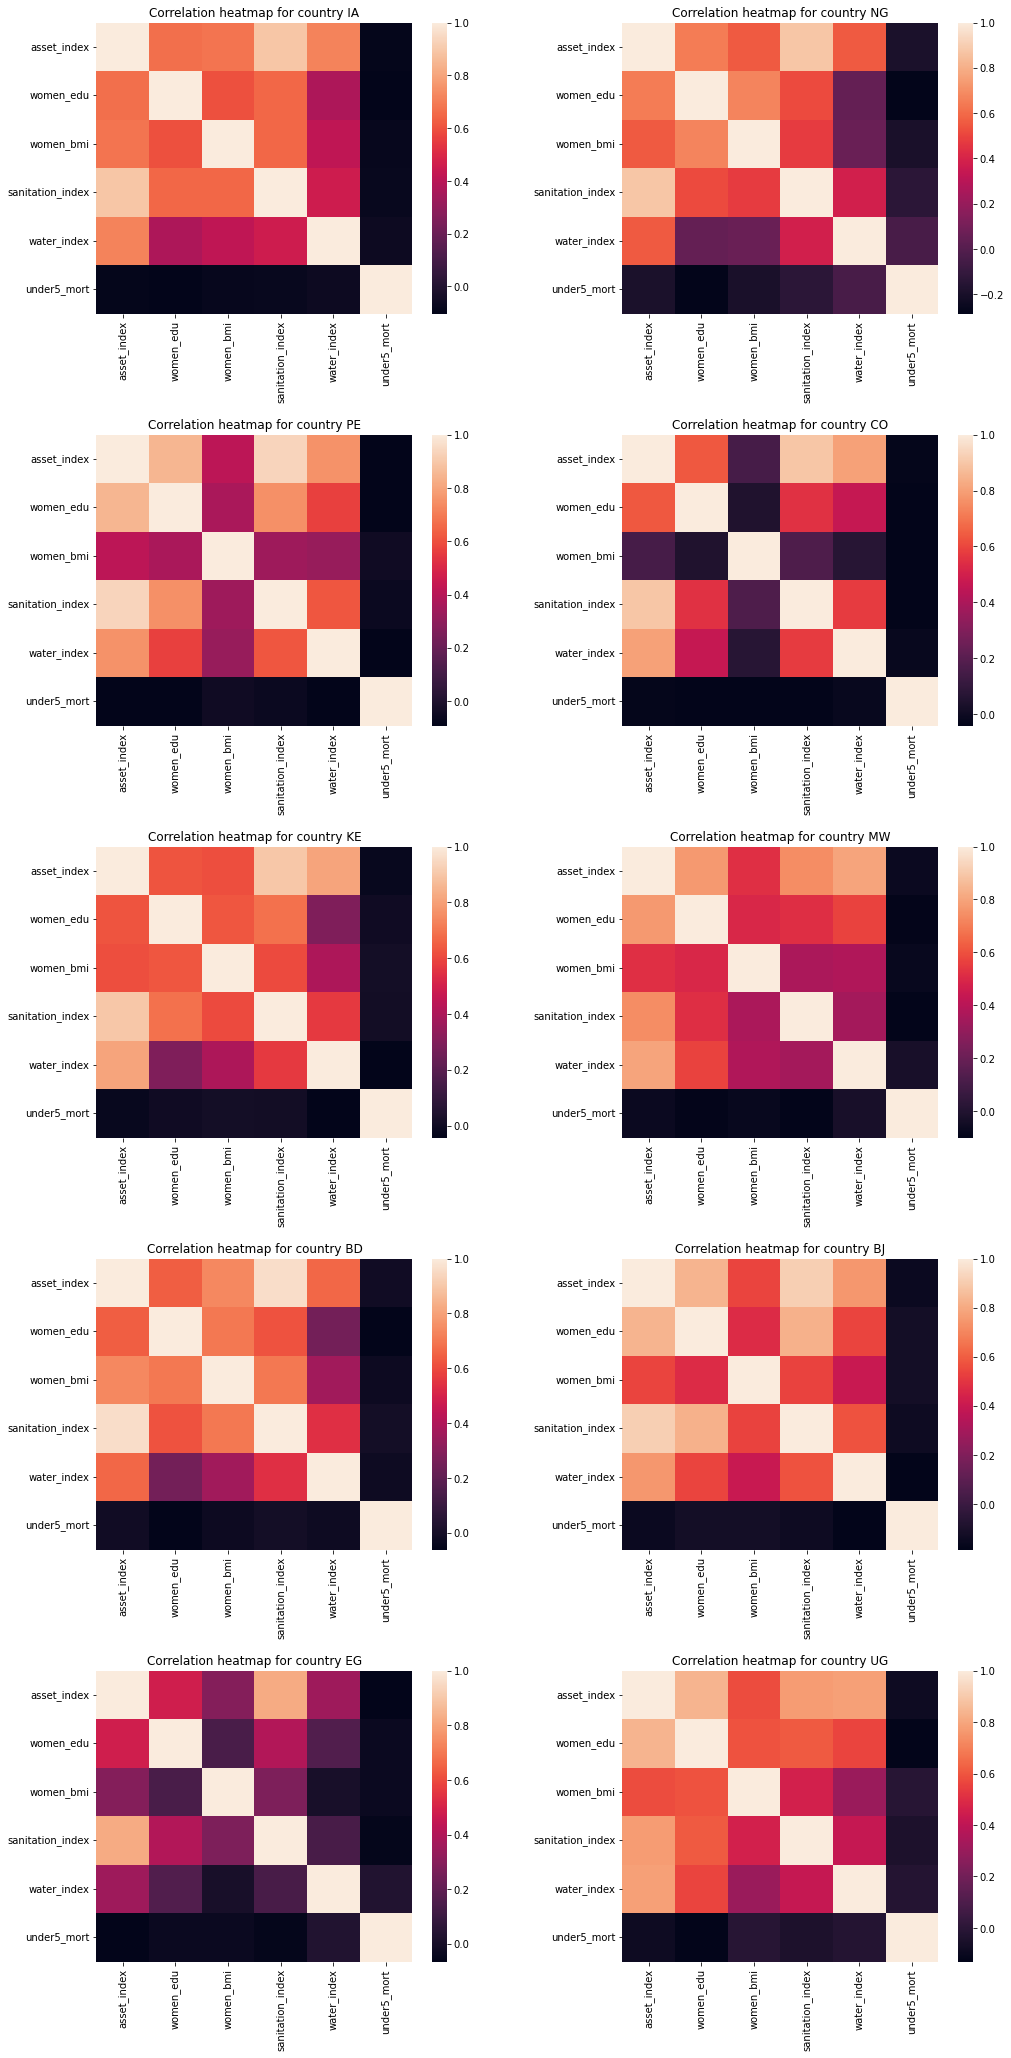

In [41]:
fig, axs = plt.subplots(5, 2, figsize=(16,30))
plt.tight_layout(pad=10.0)
axs = axs.flatten()

for i, cname in enumerate(top_n_countries):
    ax = axs[i]
    ax.set_title(f'Correlation heatmap for country {cname}')
    country_df = gdf[gdf.cname == cname][features].dropna()
    sns.heatmap(country_df.corr(), ax=ax)

In [42]:
gdf[f'in_top_{n}_surveyed_countries'] = gdf.cname.isin(top_n_countries)

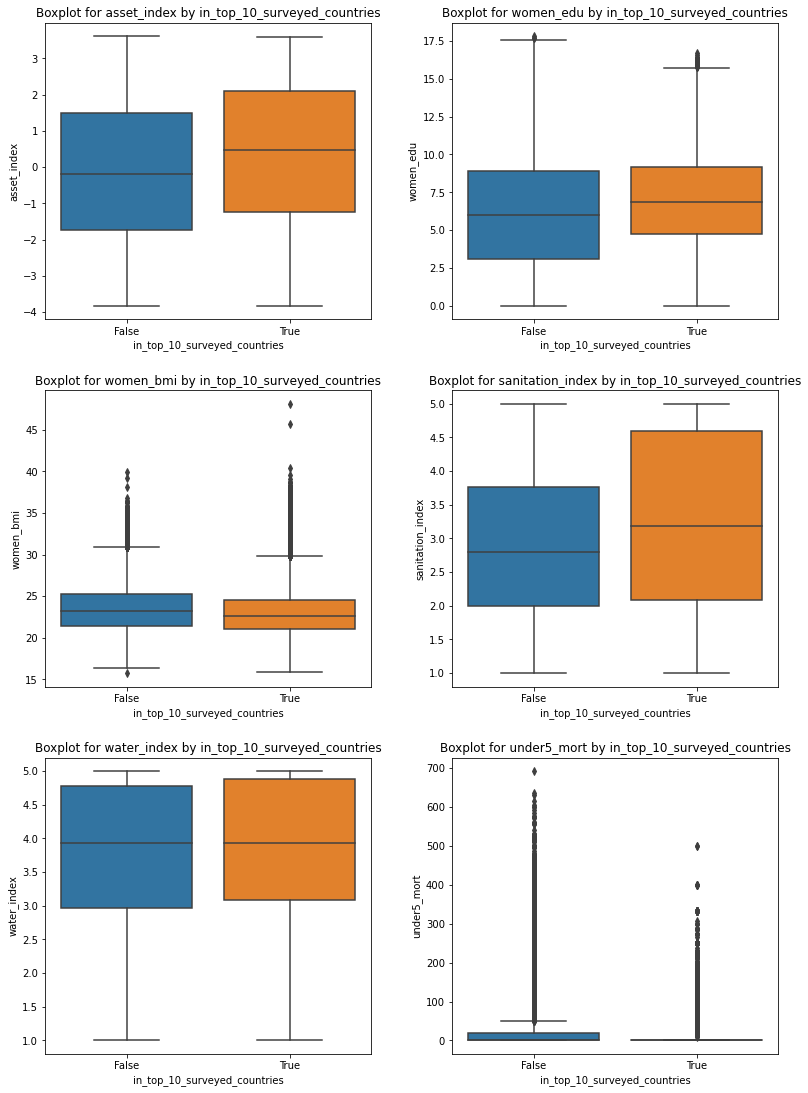

In [43]:
fig, axs = plt.subplots(3, 2, figsize=(12,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by in_top_{n}_surveyed_countries')
    sns.boxplot(data=gdf, x=f'in_top_{n}_surveyed_countries', y=feature, ax=ax)

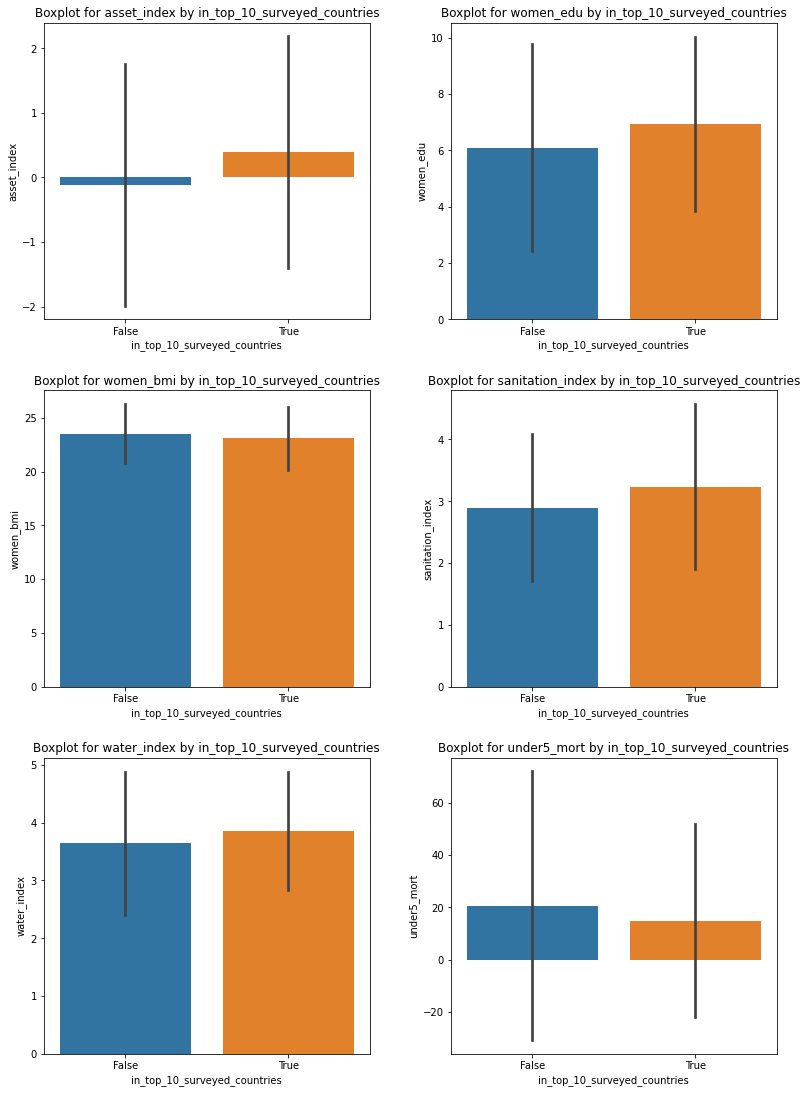

In [44]:
fig, axs = plt.subplots(3, 2, figsize=(12,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by in_top_{n}_surveyed_countries')
    sns.barplot(data=gdf, x=f'in_top_{n}_surveyed_countries', y=feature, estimator=np.mean, ci='sd', ax=ax)

In [45]:
top_countries_normalized = gdf[['cname', 'pop_est']].merge(gdf.dropna().groupby('cname').size().reset_index(), on='cname').drop_duplicates('cname')
top_countries_normalized['normalized_size'] = top_countries_normalized[0] / top_countries_normalized['pop_est']
top_n_countries_normalized = top_countries_normalized.sort_values(by='normalized_size', ascending=False)[:n]
top_n_countries_normalized.head(n)

,cname,pop_est,0,normalized_size
56816,LS,1958042.0,679,0.000347
68986,NM,2484780.0,850,0.000342
24615,GY,737718.0,178,0.000241
55432,LB,4689021.0,929,0.000198
78097,SL,6163195.0,1125,0.000183
81872,SZ,1467152.0,242,0.000165
21230,GA,1772255.0,290,0.000164
5385,BJ,11038805.0,1276,0.000116
24925,HT,10646714.0,1107,0.000104
76411,RW,11901484.0,980,0.000082


In [46]:
np.sum(top_n_countries_normalized.reset_index()[0]) / gdf.shape[0]

0.07398173648354835

In [47]:
top_n_countries_normalized = list(top_n_countries_normalized['cname'])

In [48]:
gdf[f'in_top_{n}_surveyed_countries_normalized'] = gdf.cname.isin(top_n_countries_normalized)

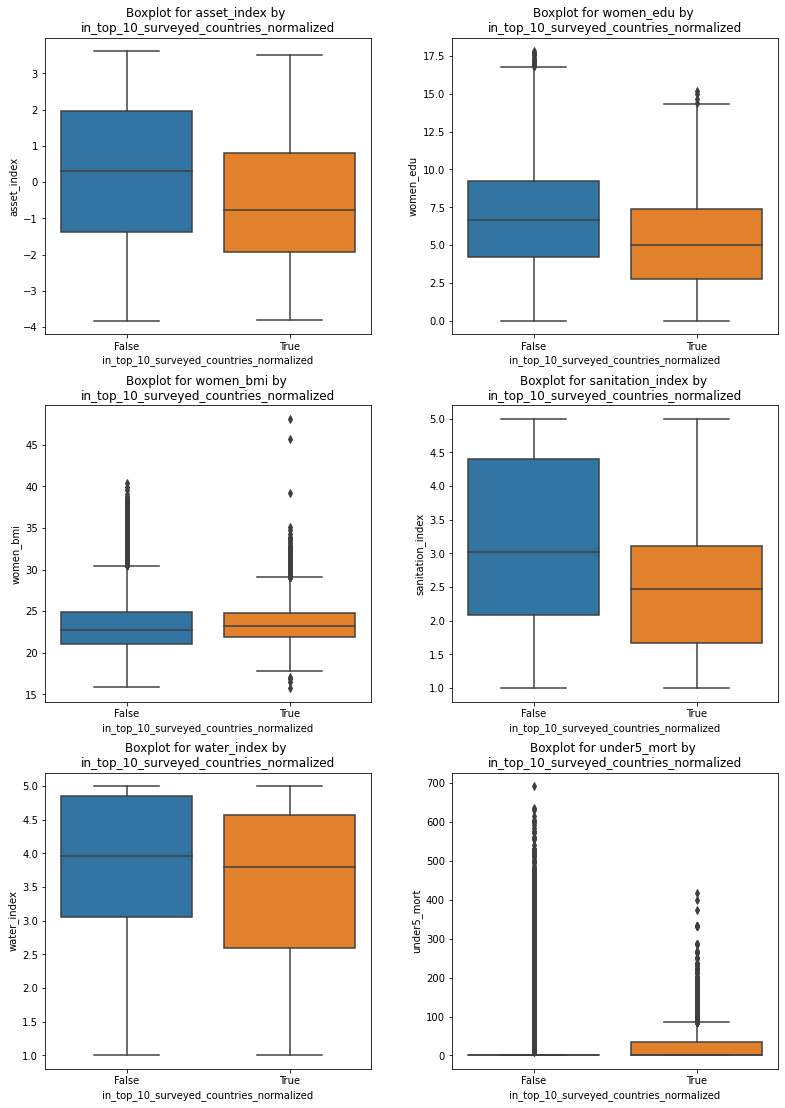

In [49]:
fig, axs = plt.subplots(3, 2, figsize=(12,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by \nin_top_{n}_surveyed_countries_normalized')
    sns.boxplot(data=gdf, x=f'in_top_{n}_surveyed_countries_normalized', y=feature, ax=ax)

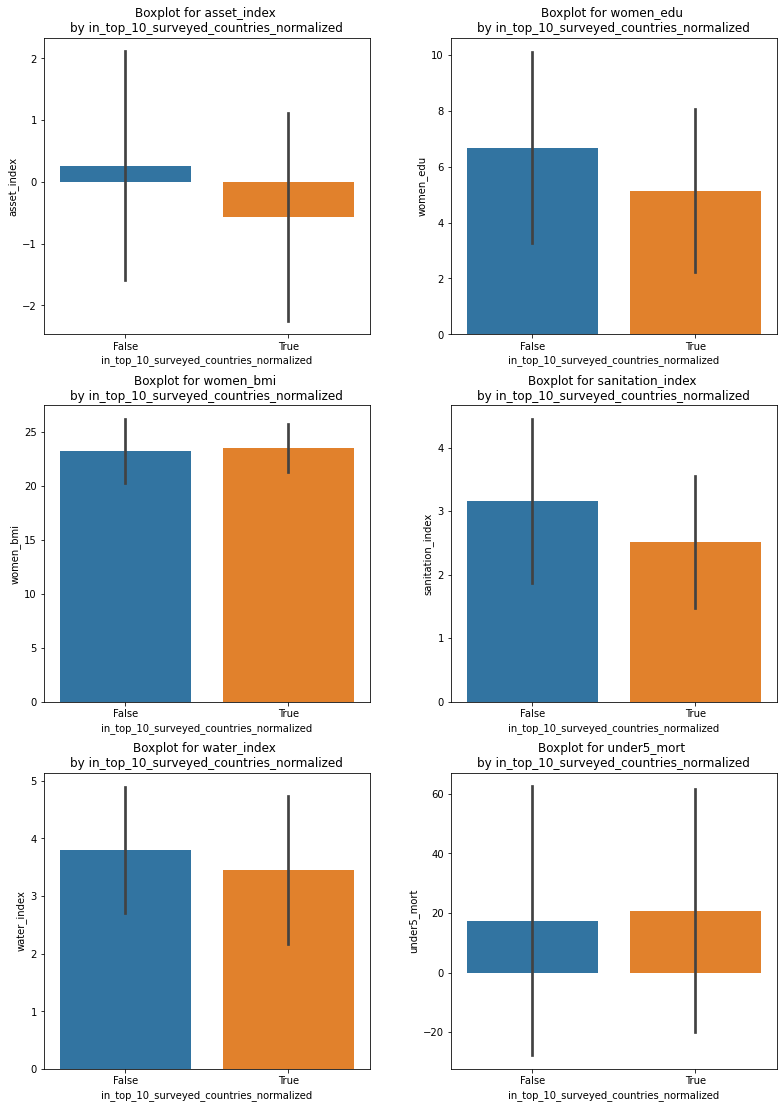

In [50]:
fig, axs = plt.subplots(3, 2, figsize=(12,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} \nby in_top_{n}_surveyed_countries_normalized')
    sns.barplot(data=gdf, x=f'in_top_{n}_surveyed_countries_normalized', y=feature, estimator=np.mean, ci='sd', ax=ax)

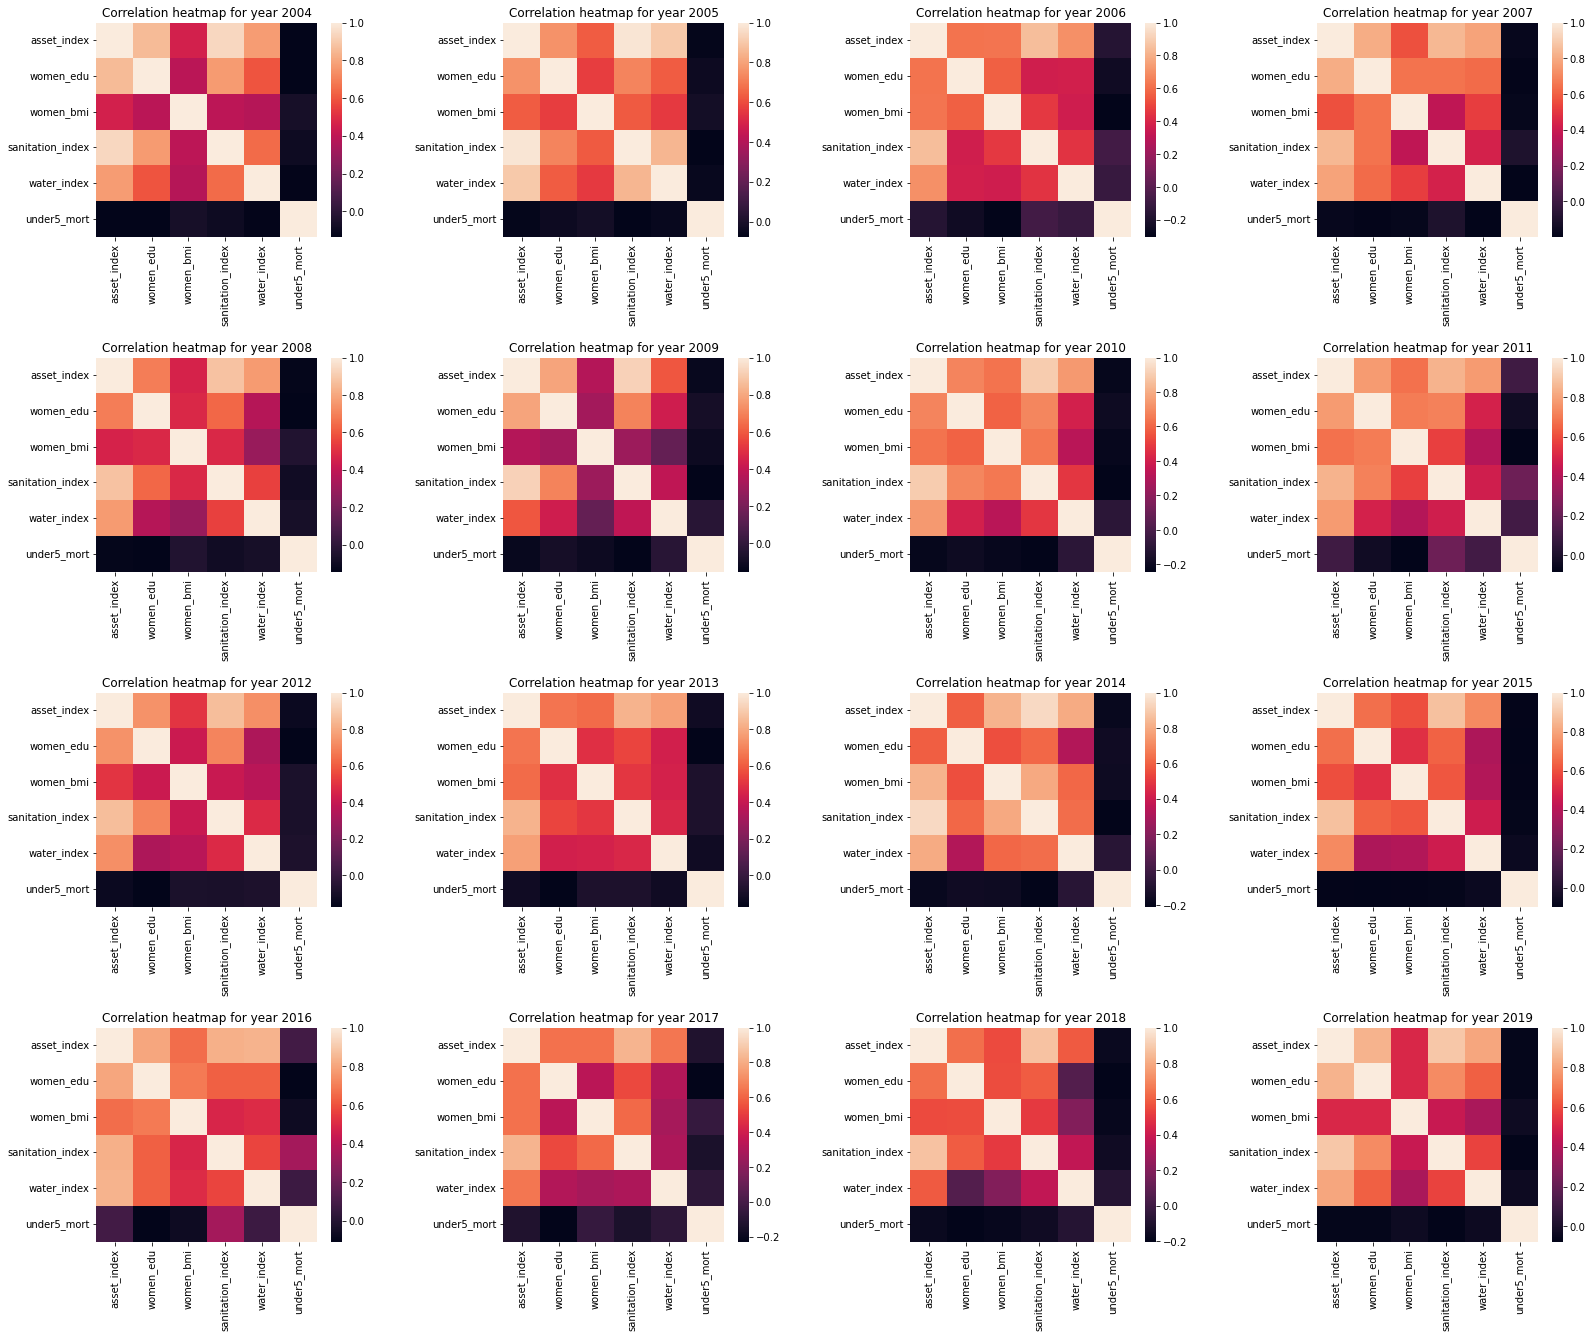

In [51]:
fig, axs = plt.subplots(4, 4, figsize=(24,20))
plt.tight_layout(pad=10.0)
axs = axs.flatten()

for i, year in enumerate(sorted(gdf.year.unique())):
    ax = axs[i]
    ax.set_title(f'Correlation heatmap for year {year}')
    year_df = gdf[gdf.year == year][features].dropna()
    sns.heatmap(year_df.corr(), ax=ax)

In [52]:
sum(gdf.under5_mort.isna()) / gdf.shape[0]

0.10428564526259844

In [53]:
sum(gdf.under5_mort > 0) / gdf.shape[0]

0.20054114122819733

## Appendix: EDA at continent level

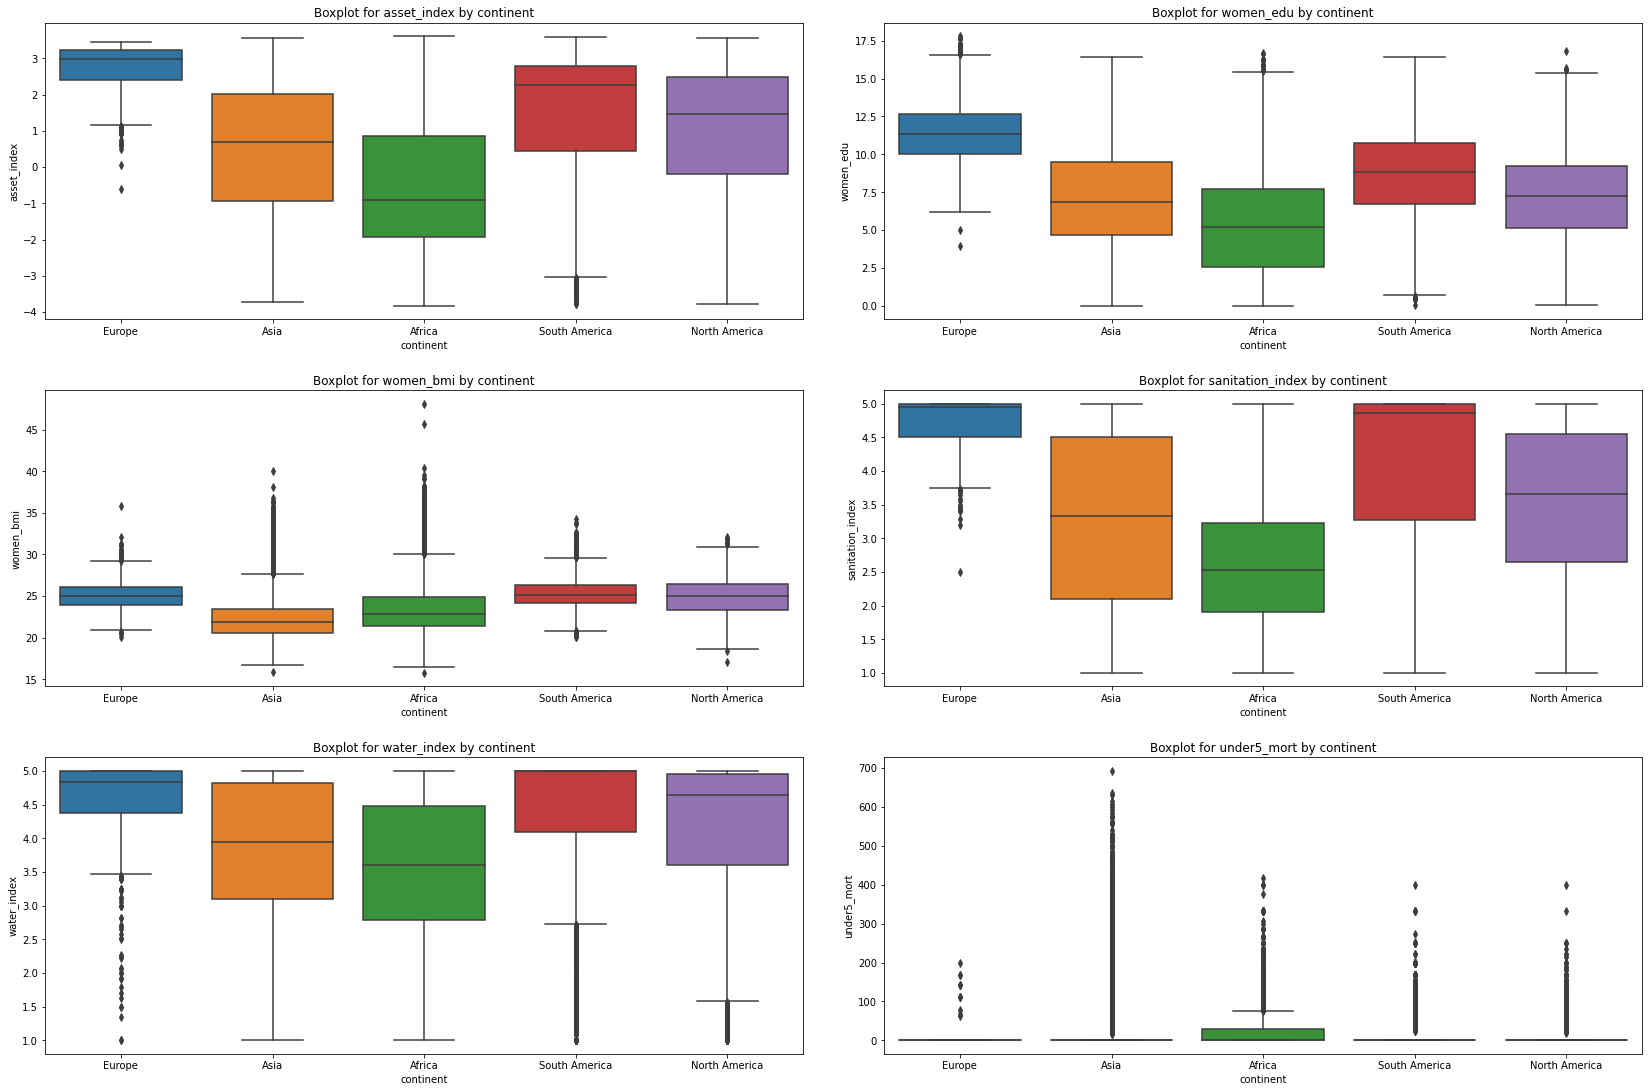

In [54]:
fig, axs = plt.subplots(3, 2, figsize=(24,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by continent')
    sns.boxplot(data=gdf, x='continent', y=feature, ax=ax)

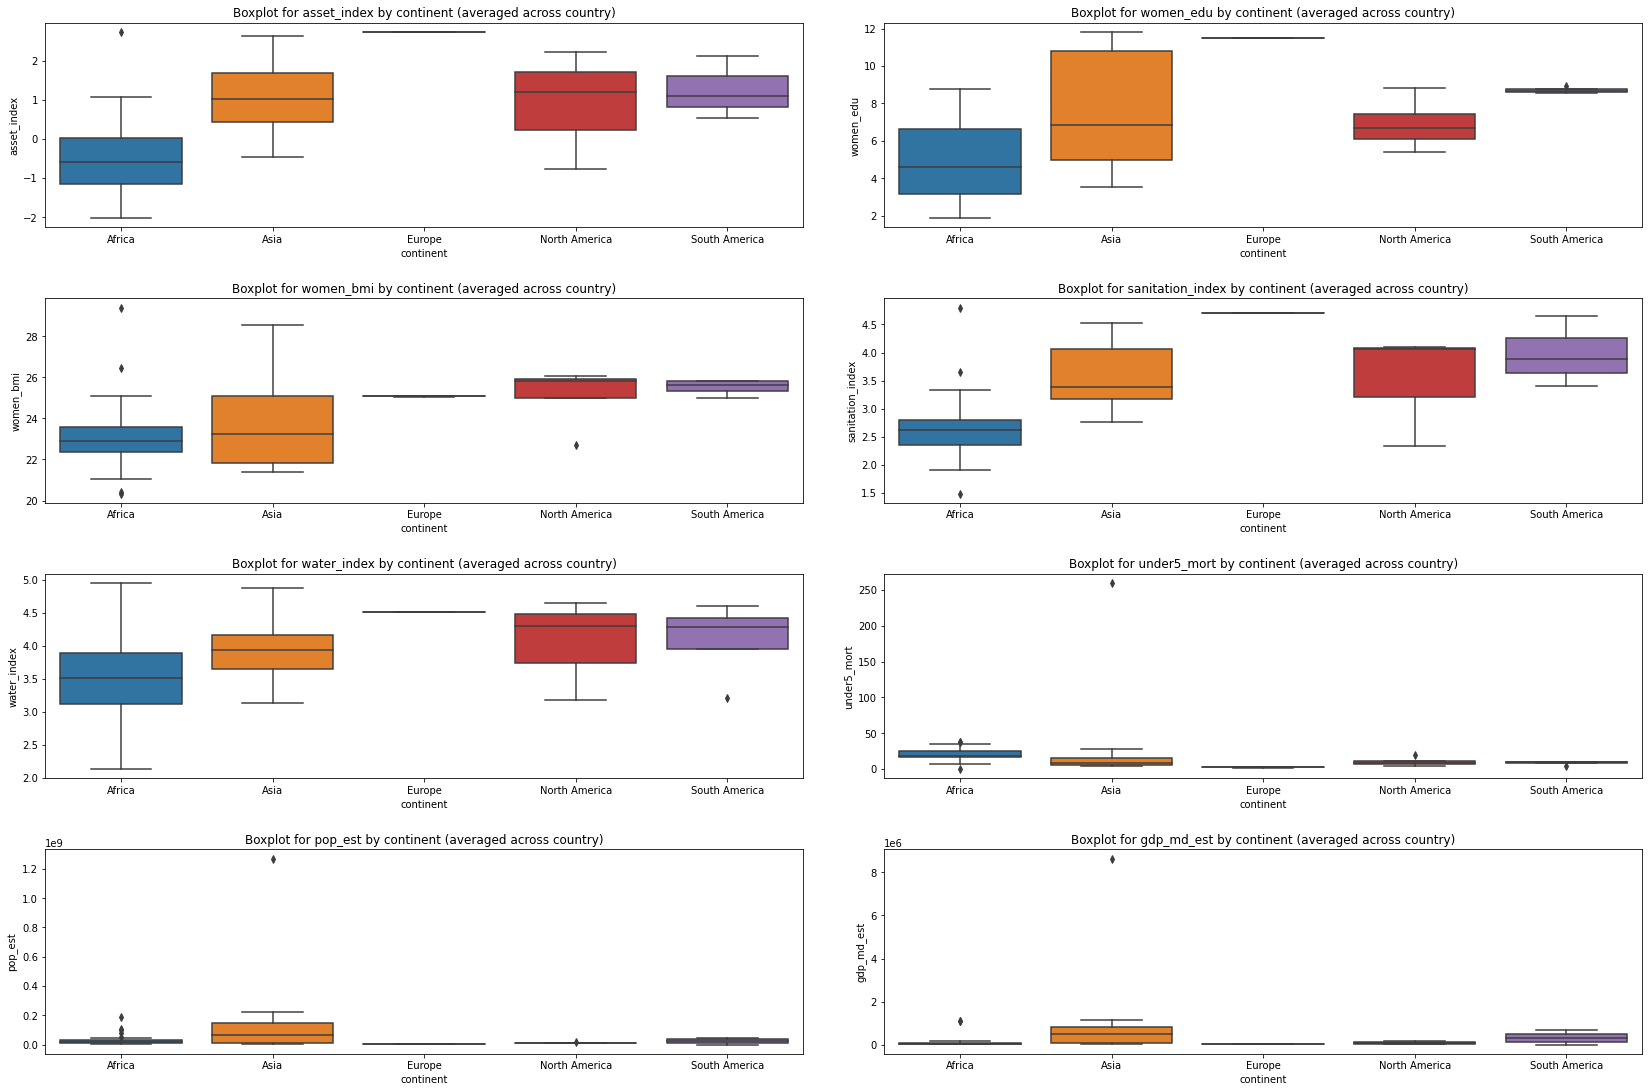

In [55]:
country_level_features = features + ['pop_est', 'gdp_md_est']

fig, axs = plt.subplots(4, 2, figsize=(24,16))
plt.tight_layout(pad=5.0)
axs = axs.flatten()

for i, feature in enumerate(country_level_features):
    ax = axs[i]
    ax.set_title(f'Boxplot for {feature} by continent (averaged across country)')
    sns.boxplot(data=gdf.groupby(['continent', 'cname']).mean().reset_index(), x='continent', y=feature, ax=ax)

/Users/caravanuden/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/caravanuden/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


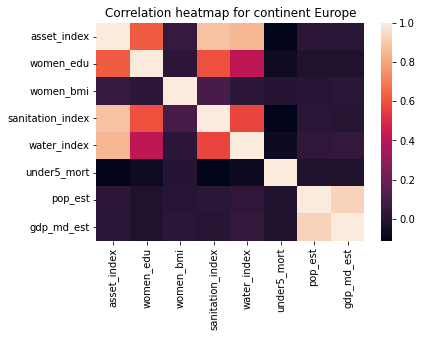

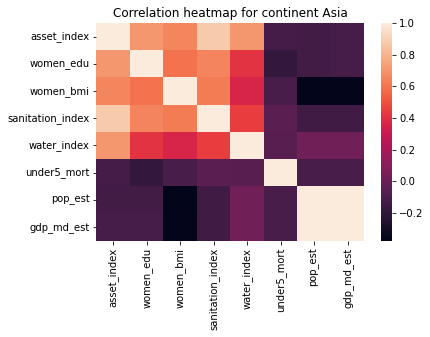

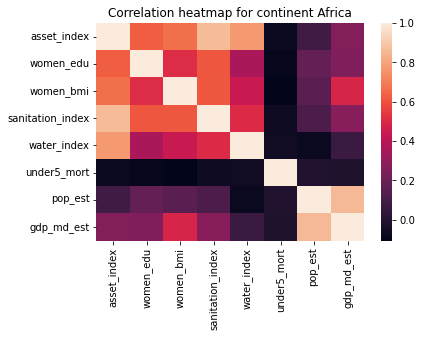

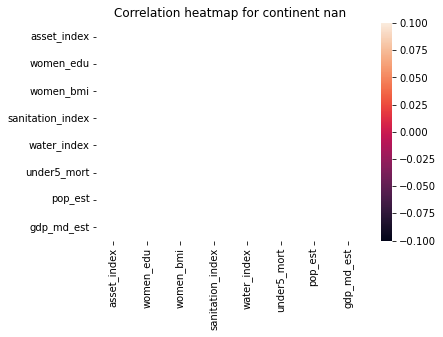

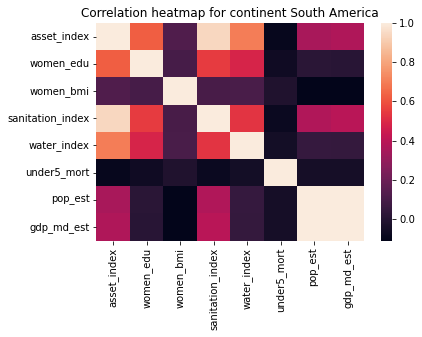

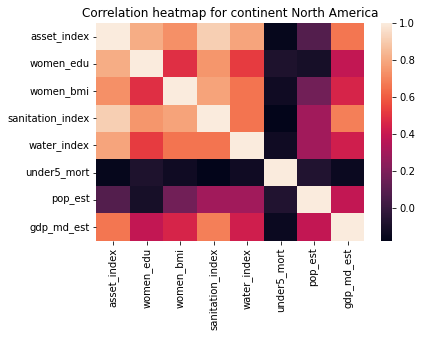

In [56]:
for continent in continents:
    plt.figure()
    plt.title(f'Correlation heatmap for continent {continent}')
    sns.heatmap(gdf[gdf.continent == continent][country_level_features].corr())